In [1]:
!pip install -q tqdm
!git clone -b experimental https://git@github.com/wenkesj/alchemy.git ~/alchemy
!(cd ~/alchemy; pip install -q .)

fatal: destination path '/content/alchemy' already exists and is not an empty directory.


In [0]:
from observations import mnist

(x_train, y_train), (x_test, y_test) = mnist('data')
train_size, test_size = len(x_train), len(x_test)

# Shared Model Body for comparison

In [0]:
import alchemy as ay
import tensorflow as tf

def model_fn(inputs_ph):
  inputs = tf.reshape(inputs_ph, [tf.shape(inputs_ph)[0], 28, 28, 1])
  y = tf.layers.conv2d(tf.cast(inputs, tf.float32) / 127, 32, (3, 3), 
                       activation=tf.nn.relu)
  y = tf.layers.conv2d(y, 64, (3, 3), activation=tf.nn.relu)
  y = tf.contrib.layers.flatten(y)
  return y

In [0]:
import numpy as np
import sys
from tqdm import trange

epochs = 3
batch_size = 64
learning_rate = 6.25e-4


def train_fn(model):
  tf.reset_default_graph()
  tf.set_random_seed(42)
  np.random.seed(42)

  tf.reset_default_graph()
  
  inputs_ph = tf.placeholder(tf.uint8, (None, 784), name='inputs')
  labels_ph = tf.placeholder(tf.int32, (None,), name='labels')

  logits = model_fn(inputs_ph)
  logits = model(logits)

  pred_op = tf.argmax(logits, axis=-1, output_type=tf.int32)
  accy_op = tf.reduce_mean(
      tf.cast(tf.equal(pred_op, labels_ph), tf.float32), axis=-1)
  loss_op = tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=labels_ph, logits=logits, name='loss'),
      axis=-1)
  train_op = tf.train.AdamOptimizer(
      learning_rate=learning_rate).minimize(loss_op)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    accuracies = []
    for epoch in range(epochs):
      train_loss = 0.
      train_set = ay.utils.generate_dataset((x_train, y_train), batch_size)
      train_msg = 'Epoch {} mean train loss = {:.4f}'
      train_range = trange(
          train_size // batch_size, 
          desc=train_msg.format(epoch, train_loss),
          file=sys.stdout)
      for _ in train_range:
        x, y = next(train_set)
        train_loss, _ = sess.run((loss_op, train_op), feed_dict={
            inputs_ph: x,
            labels_ph: y, 
        })
        train_range.set_description(train_msg.format(epoch, train_loss))

      test_accy = 0.
      test_set = ay.utils.generate_dataset((x_test, y_test), batch_size)
      for test_steps_taken in range(test_size // batch_size):
        x, y = next(test_set)
        test_accy_ = sess.run(accy_op, feed_dict={
            inputs_ph: x,
            labels_ph: y,
        })
        test_accy += test_accy_
      accy = 100. * (test_accy / (test_steps_taken + 1))
      accuracies.append(accy)
      print('Epoch {} accy {:.2f}%'.format(epoch, accy))
    return accuracies

# Compare the 2 implementations (Dense vs. Dense + Lateral)

In [0]:
def dense(logits):
  logits = tf.layers.dense(logits, units=128, activation=tf.nn.relu)
  return tf.layers.dense(logits, units=10)

def lateral_with_self_connections(logits):
  logits = tf.layers.dense(logits, units=128, activation=None)
  logits = ay.contrib.layers.lateral(
      logits, allow_self_connections=True, activation=tf.nn.relu)
  logits = tf.layers.dense(logits, units=10)
  return ay.contrib.layers.lateral(logits, allow_self_connections=True)

def lateral_with_self_connections_fixed(logits):
  logits = tf.layers.dense(logits, units=128, activation=None)
  logits = ay.contrib.layers.lateral(
      logits, allow_self_connections=True, 
      activation=tf.nn.relu, trainable=False)
  logits = tf.layers.dense(logits, units=10)
  return ay.contrib.layers.lateral(
      logits, allow_self_connections=True, trainable=False)

def lateral_without_self_connections(logits):
  logits = tf.layers.dense(logits, units=128, activation=None)
  logits = ay.contrib.layers.lateral(logits, activation=tf.nn.relu)
  logits = tf.layers.dense(logits, units=10)
  return ay.contrib.layers.lateral(logits)

def lateral_without_self_connections_fixed(logits):
  logits = tf.layers.dense(logits, units=128, activation=None)
  logits = ay.contrib.layers.lateral(
      logits, activation=tf.nn.relu, trainable=False)
  logits = tf.layers.dense(logits, units=10)
  return ay.contrib.layers.lateral(
      logits, trainable=False)

models = [
    dense, 
    lateral_with_self_connections, 
    lateral_with_self_connections_fixed,
    lateral_without_self_connections,
    lateral_without_self_connections_fixed]

Epoch 0 mean train loss = 0.3658: 100%|██████████| 937/937 [00:21<00:00, 42.69it/s]
Epoch 0 accy 98.29%
Epoch 1 mean train loss = 0.0077:   3%|▎         | 30/937 [00:00<00:20, 43.89it/s]

Epoch 1 mean train loss = 0.3117: 100%|██████████| 937/937 [00:20<00:00, 46.34it/s]
Epoch 1 accy 98.61%
Epoch 2 mean train loss = 0.0095:   5%|▍         | 44/937 [00:00<00:19, 46.17it/s]

Epoch 2 mean train loss = 0.2105: 100%|██████████| 937/937 [00:20<00:00, 46.07it/s]
Epoch 2 accy 98.72%
Epoch 0 mean train loss = 0.3934:   5%|▍         | 46/937 [00:01<00:24, 36.72it/s]

Epoch 0 mean train loss = 0.4670: 100%|██████████| 937/937 [00:21<00:00, 44.47it/s]
Epoch 0 accy 98.21%
Epoch 1 mean train loss = 0.0211:   5%|▌         | 50/937 [00:01<00:20, 43.11it/s]

Epoch 1 mean train loss = 0.3900: 100%|██████████| 937/937 [00:21<00:00, 44.56it/s]
Epoch 1 accy 97.48%
Epoch 2 mean train loss = 0.0124:   5%|▌         | 50/937 [00:01<00:21, 40.90it/s]

Epoch 2 mean train loss = 0.2552: 100%|██████████| 937/937 [00:20<00:00, 44.67it/s]
Epoch 2 accy 98.29%
Epoch 0 mean train loss = 0.4591:   5%|▌         | 51/937 [00:01<00:21, 40.82it/s]

Epoch 0 mean train loss = 0.2787: 100%|██████████| 937/937 [00:21<00:00, 44.42it/s]
Epoch 0 accy 97.94%
Epoch 1 mean train loss = 0.0772:   5%|▌         | 50/937 [00:01<00:20, 42.91it/s]

Epoch 1 mean train loss = 0.2943: 100%|██████████| 937/937 [00:20<00:00, 46.31it/s]
Epoch 1 accy 98.04%
Epoch 2 mean train loss = 0.0448:   5%|▌         | 51/937 [00:01<00:21, 41.54it/s]

Epoch 2 mean train loss = 0.2305: 100%|██████████| 937/937 [00:20<00:00, 45.56it/s]
Epoch 2 accy 98.58%
Epoch 0 mean train loss = 0.3158:   5%|▌         | 50/937 [00:01<00:25, 35.45it/s]

Epoch 0 mean train loss = 0.3061: 100%|██████████| 937/937 [00:22<00:00, 42.47it/s]
Epoch 0 accy 98.51%
Epoch 1 mean train loss = 0.0490:   5%|▌         | 51/937 [00:01<00:20, 42.52it/s]

Epoch 1 mean train loss = 0.2178: 100%|██████████| 937/937 [00:21<00:00, 43.88it/s]
Epoch 1 accy 98.83%
Epoch 2 mean train loss = 0.0055:   5%|▌         | 51/937 [00:01<00:21, 41.35it/s]

Epoch 2 mean train loss = 0.2017: 100%|██████████| 937/937 [00:21<00:00, 44.15it/s]
Epoch 2 accy 98.43%
Epoch 0 mean train loss = 0.2585:   6%|▌         | 52/937 [00:01<00:21, 41.12it/s]

Epoch 0 mean train loss = 0.4705: 100%|██████████| 937/937 [00:20<00:00, 44.79it/s]
Epoch 0 accy 97.91%
Epoch 1 mean train loss = 0.0472:   5%|▌         | 51/937 [00:01<00:19, 44.43it/s]

Epoch 1 mean train loss = 0.4078: 100%|██████████| 937/937 [00:20<00:00, 45.89it/s]
Epoch 1 accy 97.81%
Epoch 2 mean train loss = 0.0415:   5%|▌         | 51/937 [00:01<00:21, 41.97it/s]

Epoch 2 mean train loss = 0.1254: 100%|██████████| 937/937 [00:19<00:00, 47.32it/s]
Epoch 2 accy 98.67%


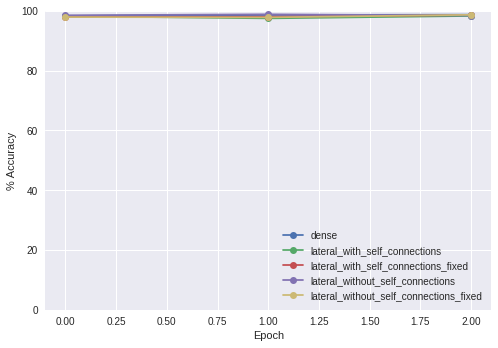

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_ylabel('% Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim([0, 100.])
for name, accuracies in [(model.__name__, train_fn(model)) 
                         for model in models]:
  ax.plot(accuracies, marker='o', label=name)
_ = ax.legend(loc='lower right', shadow=True)